# Projeto 2 - Ciência dos Dados

Nome: Eiki Luis Yamashiro 

Nome: Marcelo Cesário Miguel

Turma: 2A ENGENHARIA

___
# Classificador automático de sentimento


## Preparando o ambiente no jupyter:

In [491]:
%%capture

#Instalando o tweepy
!pip install tweepy
!pip install emoji --upgrade

In [492]:
%matplotlib inline
import tweepy
import math
import os.path
import json
from random import shuffle
import matplotlib.pyplot as plt
import pandas as pd
from emoji import UNICODE_EMOJI

___
## Autenticando no  Twitter

* Conta: @EikiMarcelo

___
## Etapas do projeto:

### Escolha de um produto e coleta das mensagens


Capturando os dados do twitter:

Salvando os dados em uma planilha Excel:

___
### Classificando as mensagens na coragem

Esta etapa é manual. Faça a mesma pelo Excel.

### <font color = 'blue'> Item 1) Limpando as pontuações das frases: </font>

In [493]:
#def de limpar palavras
import re 

def cleanup(text):
    """
        Função de limpeza muito simples que troca alguns sinais básicos por espaços
    """
    punctuation = '[!)"(\-/.\n:?;]' # Note que os sinais [] são delimitadores de um conjunto.
    pattern = re.compile(punctuation)
    text_subbed = re.sub(pattern, ' ', text)
    return text_subbed
#Excel
skol_read=pd.read_excel("skol.xlsx")

### <font color = 'blue'>Item 2) Separando emoji de outros emoji e str por espaços:</font>

In [494]:
#Def criar espaço entre emoji e str
def is_emoji(s):
    return s in UNICODE_EMOJI

# add space near your emoji
def add_space(text):
    return ''.join(' ' + char if is_emoji(char) else char for char in text).strip()

In [495]:
#Limpeza e separação por relevancia
results=[cleanup(text) for text in skol_read.Treinamento]
skol_read.Treinamento=results
skol_read.rename(columns={'Unnamed: 1':'relevante'},inplace=True)
results=[add_space(text) for text in skol_read.Treinamento]
skol_read.Treinamento= results

# Excel dos Testes
skol_read_teste=pd.read_excel("skol.xlsx","Teste")
results=[cleanup(text) for text in skol_read_teste.Teste]
skol_read_teste.Teste=results
skol_read_teste.rename(columns={'Unnamed: 1':'relevante'},inplace=True)
results=[add_space(text) for text in skol_read_teste.Teste]
skol_read_teste.Teste= results

#Relevante 0
skol_relevante_0=skol_read[skol_read.relevante==0]

#Relevante 1
skol_relevante_1=skol_read[skol_read.relevante==1]
print ("Len relevante 0:",len(skol_relevante_0),"",
       "Len relevante 1:",len(skol_relevante_1))

Len relevante 0: 185  Len relevante 1: 115


In [496]:
# Separando as palavras Relevancia 1
" ".join(skol_relevante_1["Treinamento"]).split()
palavras=pd.DataFrame("".join(skol_relevante_1["Treinamento"]).split())
palavras_relevancia_1=palavras[0].value_counts()
#Tabela Relativa 
palavras_relevancia_1_relativa=palavras[0].value_counts(True)

In [497]:
# Separando as palavras Relevancia 0
" ".join(skol_relevante_0["Treinamento"]).split()
palavras=pd.DataFrame("".join(skol_relevante_0["Treinamento"]).split())
palavras[0].value_counts()
palavras_relevancia_0=palavras[0].value_counts()
palavras_relevancia_0

#Tabela Relativa 
palavras_relevancia_0_relativa=palavras[0].value_counts(True)

___
### Montando o Classificador Naive-Bayes

Para ensinar o classificador, iremos nos basear no Teorema de Bayes.

In [498]:
#   Definindo a função que recebe o dataframe, e uma string que define se é o 'Treinamento' ou o 'Teste'. A função retorna uma
#lista com valores dos indices 1 ou 0. Sendo 1 para relevante e 0 para irrelevante.
def classificador(dataframe,plani):
#============================================PARTE===UM===DA===FUNÇÃO==========================================================

#-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_Relevância-_-_Zero-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_

#--------------------------------------------Criando--uma--lista--de--frases---------------------------------------------------

#A lista_frase, é uma lista que os indices são strings que são as frases. Já a lista_palavra, é uma lista que os indices são
#listas onde cada indice é uma palavra. 
#Exemplo: 
#lista_frase==['Oi tudo bem', 'Meu nome é Eiki']
#lista_palavra==[['Oi','tudo','bem'],['Meu','nome','é','Eiki']]
    i=0
    lista_frase=[]
    lista_palavra = []
    if plani == 'Teste':
        while i <=199:
            a=skol_read_teste.loc[i,'{0}'.format(plani)]
            lista_frase.append(a)
            x = lista_frase[i].split(" ")
            lista_palavra.append(x)
            i+=1
        lista_palavra
    else:
        while i <=299:
            a=skol_read.iloc[i,0]
            lista_frase.append(a)
            x = lista_frase[i].split(" ")
            lista_palavra.append(x)
            i+=1
        lista_palavra
#-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_Chutando-_-_o-_-_numero-_-_de-_-_palavras-_-_PT-_-_BR-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-
    t = 1/500000
#-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_Laplace-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-   

#-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_

#A função irá usar a string que define se é o teste ou o treinamento para dar o valor exato para a variável "var".
#A lista mult_prob é uma lista que contém mais listas, que possuem o valor da probabilidade de cada palavra em relação à 
#relevância 0, e a lista produto_prob, é uma lista que já contém a probabilidade de cada frase.
    i = 0
    produto_prob = []
    if plani == "Teste":
        var = 199
    else:
        var = 299
    while i <= var:
        k = 0
        mult_prob = []
        while k < len(lista_palavra[i]):
            palavra = lista_palavra[i][k]
            if palavra not in palavras_relevancia_0_relativa:
                prob = t
            else:
                prob = palavras_relevancia_0_relativa[palavra] + t
            mult_prob.append(prob)
            k+=1
        logp = 0
#-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-Smoothing_-_-de_-_-Laplace_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_
        for e in mult_prob:
            logp=logp+math.log(e)
        produto = logp
        produto_prob.append(produto)
        i+=1
    Lista_prob_0 = produto_prob
#============================================PARTE===DOIS===DA===FUNÇÃO========================================================

#-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_Relevância-_-_Um-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_

#Os mesmos passos feitos na parte um da função serão repetidos na parte dois, entretanto será a probabilidade em relação 
#à relevância 1.
    i=0
    lista_frase=[]
    lista_palavra = []
    if plani == 'Teste':
        while i <=199:
            a=skol_read_teste.loc[i,'{0}'.format(plani)]
            lista_frase.append(a)
            x = lista_frase[i].split(" ")
            lista_palavra.append(x)
            i+=1
        lista_palavra
    else:
        while i <=299:
            a=skol_read.iloc[i,0]
            lista_frase.append(a)
            x = lista_frase[i].split(" ")
            lista_palavra.append(x)
            i+=1
        lista_palavra
    i = 0
    produto_prob = []
    if plani == "Teste":
        var = 199
    else:
        var = 299
    while i <= var:
        k = 0
        mult_prob = []
        while k < len(lista_palavra[i]):
            palavra = lista_palavra[i][k]
            if palavra not in palavras_relevancia_1_relativa:
                prob = t
            else:
                prob = palavras_relevancia_1_relativa[palavra] + t
            mult_prob.append(prob)
            k+=1
        logp = 0
        for e in mult_prob:
            logp=logp+math.log(e)
        produto = logp
        produto_prob.append(produto)
        i+=1
    Lista_prob_1 = produto_prob
#============================================PARTE===TRÊS===DA===FUNÇÃO========================================================

#-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-Classifica_-_-em_-_-1_-_-ou_-_-0-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-

#Agora, a função irá comparar a probabilidade da mesma frase em relação à relevância 1 ou 0, a maior probabilidade irá definir
#se a frase é relevância 1 ou 0.
    lista_analise = []
    i=0
    analise = 0
    while i< len(Lista_prob_1):
        if Lista_prob_1[i] > Lista_prob_0[i]:
            analise = 1
        else:
            analise = 0
        lista_analise.append(analise)
        i+=1
    dataframe['Analise'] = lista_analise
    return(dataframe)

### <font color = "red"> Validando as analises:

#### Adicionando a coluna do resultado:

In [500]:
#Definindo a relevancia com o classificador
relevancia_classificada = classificador(skol_read,'Treinamento')

In [501]:
def validadora(df, relevancia, analise):
#Essa função retorna o dataframe com uma série nova, que apresenta se a classificação foi correta ou não.
#Essa função vai validar as classificações em True ou False, sendo True para a classificação correta e False para a incorreta.
    i = 0
    verifica = []
    while i < len(df):
        ver = False
        if df["{0}".format(relevancia)][i] == df["{0}".format(analise)][i]:
            ver = True
        verifica.append(ver)
        i+=1
    df['Validadora'] = verifica
    return(df)

In [502]:
skol_read = validadora(skol_read, 'relevante', 'Analise')

,Treinamento,relevante,Analise,Validadora
0,rt @2kdaladeira @whsallas @silva22anny tbm ma...,0,0,True
1,olha gente elas bebendo suco 😍 😍 com essas car...,0,0,True
2,um open de skol beats em limeira seria uma boa...,1,1,True
3,@bonagabriella kkkkk tem coisas q merecem um r...,0,0,True
4,@cecitoptop aiai tá louca nem skol beats na s...,0,0,True


###### Planilha do Skol até o momento:

In [521]:
skol_read.head(3)

,Treinamento,relevante,Analise,Validadora
0,rt @2kdaladeira @whsallas @silva22anny tbm ma...,0,0,True
1,olha gente elas bebendo suco 😍 😍 com essas car...,0,0,True
2,um open de skol beats em limeira seria uma boa...,1,1,True


##### <font color = 'red'> Definindo a função performance: </font>
    
Essa função irá verificar a performance do nosso classificador em verdadeiro positivo (frases relevantes que são classificadas como relevantes), verdadeiro negativo (frases irrelevantes que são classificadas como irrelevantes), falso positivo (frases irrelevantes classificadas como relevantes) e falso negativo (frases relevantes classificadas como irrelevantes).

In [503]:
def performance(df):
    i = 0
    dic = {}
    contagem_verdadeiro_positivo = 0
    contagem_verdadeiro_negativo = 0
    contagem_falso_positivo = 0
    contagem_falso_negativo = 0

    while i < len(df):
        if df["Validadora"][i] == True:
            if df["relevante"][i] == 1:
                contagem_verdadeiro_positivo+=1
            else:
                contagem_verdadeiro_negativo+=1
        else:
            if skol_read["relevante"][i] == 1:
                contagem_falso_positivo+=1
            else:
                contagem_falso_negativo+=1
        i+=1
    porc_v_n = contagem_verdadeiro_negativo/len(df)
    porc_v_p = contagem_verdadeiro_positivo/len(df)
    porc_f_n = contagem_falso_negativo/len(df)
    porc_f_p = contagem_falso_positivo/len(df)
    dic['Verdadeiro_Positivo'] = porc_v_p
    dic['Verdadeiro_Negativo'] = porc_v_n
    dic['Falso_Positivo'] = porc_f_p
    dic['Falso_Negativo'] = porc_f_n
    return(dic)

In [522]:
performance_ = performance(skol_read)

##### <font color = 'red'> Criando uma função para plotar gráficos: </font>
Iremos criar uma função que plotará 2 gráficos de setores. Esses gráficos apresentarão a porcentagem da performance (ser Verdadeiro ou Falso e Positivo ou Negativo)

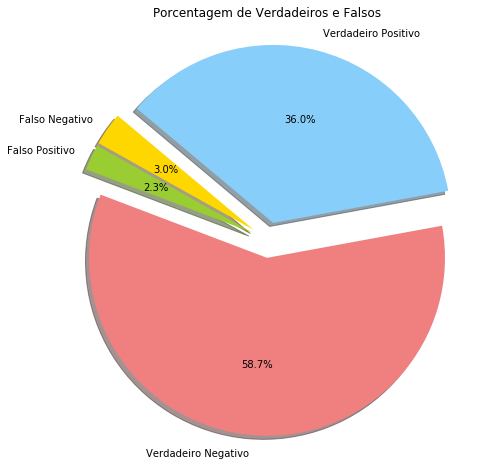

____________________________________________________________________________________________________________


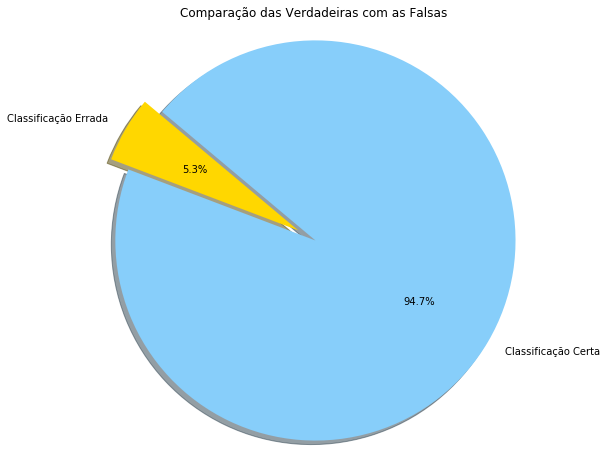

In [524]:
def plota_grafico(dic):
    # Data to plot
    labels = 'Falso Negativo', "Falso Positivo", "Verdadeiro Negativo", 'Verdadeiro Positivo'
    sizes = [dic['Falso_Negativo'], dic["Falso_Positivo"], dic["Verdadeiro_Negativo"], dic['Verdadeiro_Positivo']]
    colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
    explode = (0.1, 0.1, 0.1, 0.1)  # explode 1st slice

    # Plot
    plt.figure(figsize=[8,8])
    plt.pie(sizes, explode=explode, labels=labels, colors=colors,
    autopct='%1.1f%%', shadow=True, startangle=140)

    plt.axis('equal')
    plt.title("Porcentagem de Verdadeiros e Falsos")
    plt.show()
    print ("____________________________________________________________________________________________________________")
    classi_true = dic["Verdadeiro_Negativo"] + dic['Verdadeiro_Positivo']
    classi_false = dic['Falso_Negativo'] + dic["Falso_Positivo"]
    labels = "Classificação Errada", "Classificação Certa"
    sizes = [classi_false, classi_true]
    colors = ['gold', 'lightskyblue']
    explode = (0.05, 0.05)

    # Plot
    plt.figure(figsize=[8,8])
    plt.pie(sizes, explode=explode, labels=labels, colors=colors,
    autopct='%1.1f%%', shadow=True, startangle=140)
    plt.title("Comparação das Verdadeiras com as Falsas")
    plt.axis('equal')
    plt.show()
    
plota_grafico(performance_)

___
### Verificando a performance

Para realizar a verificação da performance, iremos usar a base de Testes, repetiremos os mesmos passos feitos para a base de Treinamento

In [525]:
skol_read_teste = classificador(skol_read_teste, 'Teste')
skol_read_teste=validadora(skol_read_teste,'relevante', 'Analise')
performance_teste=performance(skol_read_teste)

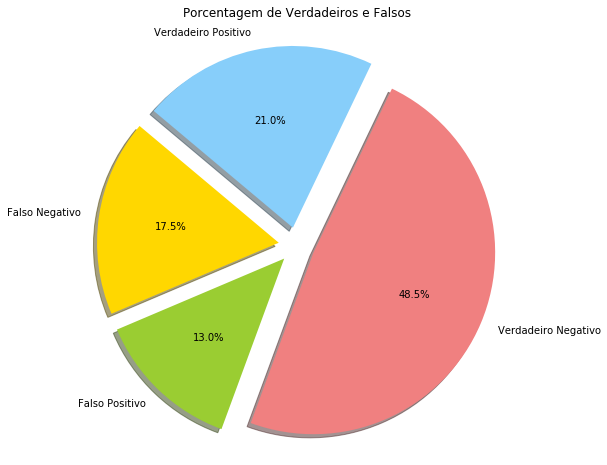

____________________________________________________________________________________________________________


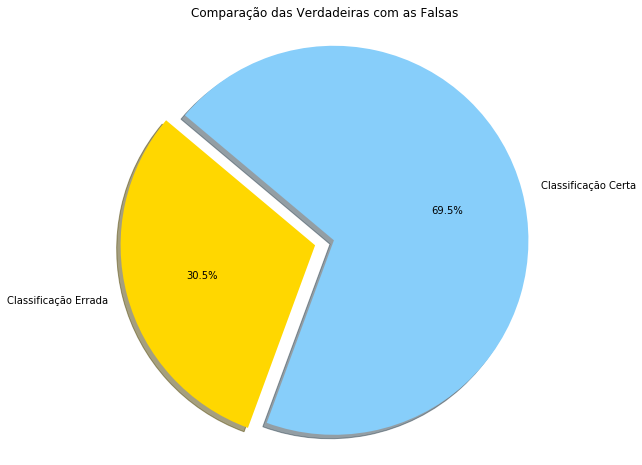

In [526]:
plota_grafico(performance_teste)

___
# Concluindo

Após a analise dos resultados, pode-se afirmar que o classificador obteve um bom desempenho, visto que houve mais classificações corretas do que erradas na base de Testes. Para aumentar o desempenho, poderiamos coletar mais tweets para obter um melhor desempenho do classificador, pois, com mais tweets, mais preciso será a analise da probabilidade de cada palavra, além de aumentar o vocabulário do classificador. 

### <font color = 'blue'>Item 3) Outras utilidades para o Naive Bayes: </font>
Além de classificar mensagens sendo relevante ou não para certo produto, o Naive Bayes também é capaz de fazer uma filtragem de SPAMs. Isso pode ser feito, treinando o classificador com históricos de frases que são consideradas SPAMs. Dessa forma, essa filtragem de SPAMs podem ser utilizadas nos comentários de redes sociais, por exemplo, para não incomodar o usuário.

Além disso, o Naive Bayes serve para mineração de dados em geral, como por exemplo caracterizar uma frase, sendo necessário apenas treinar o classificador com frases literárias e não literárias.

## <font color = 'blue'>Item 4) Proposta de limpezas e transformações: </font>
Além da nossa limpeza de sinais, outra proposta que poderia melhorar o funcionamento do classificador poderia ser a retirada de risadas, podendo ser identificada pela repetição de "k", por exemplo. Outra limpeza útil poderia ser a retirada de links, podendo retirar palavras que começam com "www.".

## <font color = 'blue'>Item 5) Por que não usar o próprio classificador para gerar mais amostras de treinamento: </font>
Não se deve usar o próprio classificador para gerar mais amostras de treinamento pelo fato de que, o classificador foi treinado baseado nas próprias amostras de treinamento, desse modo, ao gerar mais amostras de treinamento utilizando o classificador, o classificador estaria criando frases que ele ja foi treinado para lidar, fazendo com que o classificador tivesse uma analise "viciada". Além de que seria inútil do ponto de vista de aprendizagem do classificador.

## Aperfeiçoamento:

Os trabalhos vão evoluir em conceito dependendo da quantidade de itens avançados:

* Limpar: \n, :, ", ', (, ), etc SEM remover emojis <font color = 'blue'> (Item 1) </font>
* Corrigir separação de espaços entre palavras e emojis ou emojis e emojis <font color = 'blue'> (Item 2) </font>
* Propor outras limpezas e transformações que não afetem a qualidade da informação ou classificação <font color = 'blue'> (Item 4) </font>
* Criar categorias intermediárias de relevância baseadas na probabilidade: ex.: muito relevante, relevante, neutro, irrelevante, muito irrelevante (3 categorias: C, mais categorias conta para B) 
* Explicar por que não posso usar o próprio classificador para gerar mais amostras de treinamento <font color = 'blue'> (Item 5) </font>
* Propor diferentes cenários para Naïve Bayes fora do contexto do projeto <font color = 'blue'> (Item 3) </font>
* Sugerir e explicar melhorias reais com indicações concretas de como implementar (indicar como fazer e indicar material de pesquisa)
* Montar um dashboard que periodicamente realiza análise de sentimento e visualiza estes dados

# Referências

[Naive Bayes and Text Classification](https://arxiv.org/pdf/1410.5329.pdf)  **Mais completo**

[A practical explanation of a Naive Bayes Classifier](https://monkeylearn.com/blog/practical-explanation-naive-bayes-classifier/) **Mais simples**